# Assignment 2 - MC886

Thiago Dong Chen  
Naomi Takemoto

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

## Import Files and Visualize Input

In [2]:
with open('fashion-mnist_train.csv', 'rb') as csvfile:
    df = pd.read_csv('fashion-mnist_train.csv')
print(df.shape)

(60000, 785)


In [3]:
n_classes = 10
img_size = 28

img = df.loc[:, 'pixel1':].values
labels = df.loc[:,'label'].values

n_img = img.shape[0]

print('labels', labels.shape)
print('images', img.shape)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(img, labels,
                                               test_size=0.3, random_state=100)

print('train size:', X_train.shape)
print('y_train.size: ', y_train.shape)
print('validation size:', X_validation.shape)

labels (60000,)
images (60000, 784)
train size: (42000, 784)
y_train.size:  (42000,)
validation size: (18000, 784)


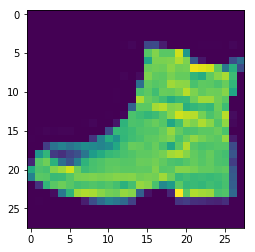

In [4]:
# visualize some example
random_int = random.randint(0, n_img-1)
example = img[random_int,:].copy()
example = np.reshape(example, (img_size, img_size))
plt.grid(False)
img_plot = plt.imshow(example)

# One vs All Logistic Regression
# **1.** Perform **Logistic Regression ** as the baseline (first solution) to learn the 10 classes in the dataset.  Use **one-vs-all** strategy to build a classification model.  Keep in mind that you should obtain 10 classification models

In [5]:
def sigmoid(z):
  """
  Arguments:
    z: a numpy array shape (nx,m), m is the number of examples and nx the number of
    features
  """
  h = 1. / (1. + np.exp(-z))
  return h

def sigmoid_cost (y, y_hat):
  """
  Arguments:
    y the target shape (m, ny)
    y__hat: the prediction (m, ny)
  """
  m = y.shape[0]
  cost = (-1./m)*np.sum(y*np.log(y_hat) + (1. - y)*np.log(1. - y_hat))
  assert(y.shape == y_hat.shape)
  return cost

def init_parameters(shape):
  """
  Arguments:
    shape a tuple with the shape (m, nx) of the input features
  Returns:
    w: the weight array shape (1,m)
    b: bias shape (m,1)
  """
  nx = shape[1]
  w = np.random.randn(nx,1)*0.001
  b = 0.
  return (w,b)

def process(data, num_classes):
  """
  Arguments:
    data: dataset loaded from csv
    num_classes: 
  Organize the data per class and scale it dividing by 255 (max pixel value)
  """
  x = np.copy(data.loc[:, 'pixel1':].values)/255.
  m = x.shape[0]
  y = np.copy(data.loc[:,'label'].values).reshape(m,1)
  return x, y

def logistic_regression (x,y,learning_rate, num_epochs):
  """
  Arguments:
    x: input, shape (m,nx)
    y: label, shape (m, 1)
    learning_rate: - 
  num_epochs: number of complete passes on the entire training set
  Returns:
   w: weight shape (nx,1)
   b: scalar
  """
  #initialize parameters
  shape = x.shape
  w,b = init_parameters(shape)
  m = shape[0]
  nx = shape[1]

  #optimize
  for epoch in range(num_epochs):

    #forward propagation
    z = np.dot(x, w) + b
    a = sigmoid(z).reshape(m,1)

    #backward propagation
    dw = (1/m)*np.dot(x.T,(a-y))
    db = (1/m)*np.sum(a - y).reshape((1,1))

    #atualize parameters
    w = w - learning_rate*(dw)
    b = b - learning_rate*(db)

    cost = sigmoid_cost(y, a)
    print('\rEpoch ',epoch, ', Cost ', cost, end = '')
    
  return (w,b)

def make_prediction(x,y,num_classes, epochs = 100):
  """
  Arguments:
    x: the input image shape (m,nx)
    y: the label shape (m, 1)
    num_classes: the number of classes
  Returns:
    predicted_class: array shape (m,1), with the class with the highest
                     probabilities
    parameters: a list with num_classes pairs (w,b).
  """
  
  #retrieve shapes
  m = x.shape[0]
  nx = x.shape[1]
 
  prob_classes = []
  parameters = []
  for class_i in range(num_classes):
    y_temp = np.where(y == class_i, 1, 0)
    #calculte the prob of the element be class_i
    w, b = logistic_regression(x,y_temp,1,epochs)
    parameters.append((w,b))
    y_hat_temp = sigmoid(np.dot(x,w) + b)
    prob_classes.append(y_hat_temp)

  #select the class with the highest prob
  prob_classes = np.asarray(prob_classes)
  predicted_class = np.empty((m,1))
  for example in range(m):
    predicted_class[example,:] = np.argmax(prob_classes[:,example,:])
  return predicted_class, parameters

def execute_k_fold (x, y, n_classes):
  """
  Executes k-fold cross valodation to k - folds
  Arguments:
    x: array shape (m, nx)
    y: array shape (m, 1)
    n_classes: the number of classes
  Returns:
    void
  """
  skf = StratifiedKFold(n_splits = 3, random_state = 1, shuffle = True)
  skf.get_n_splits(x, y)
  for train_index, validation_index in skf.split(x, y):
    
      x_train, x_validation = x[train_index], x[validation_index]
      y_train, y_validation = y[train_index], y[validation_index]

      #make prediction on training set
      predicted_classes, parameters = make_prediction(x_train,y_train, n_classes)
      mask = np.where(predicted_classes == y_train, 1, 0)
      right = np.sum(mask)
      train_size = x_train.shape[0]
      print("\nThe number of right guesses on training: ", right)
      print("On training: right/total = ", right/train_size)
      print('Training size = ', train_size)

      #make prediction on validation set
      validation_size = x_validation.shape[0]
      print('Validation Size = ', validation_size)
      prob_classes = []
      for class_i in range(n_classes):
        y_temp = np.where(y_validation == class_i, 1, 0)
        #calculte the prob of the element be class_i
        w, b = parameters [class_i]
        y_hat_temp = sigmoid(np.dot(x_validation,w) + b)
        prob_classes.append(y_hat_temp)

      #select the class with the highest prob
      prob_classes = np.asarray(prob_classes)
      predicted_class = np.empty((validation_size,1))
      for example in range(validation_size):
        predicted_class[example,:] = np.argmax(prob_classes[:,example,:])
      mask = np.where(predicted_class == y_validation, 1, 0)
      right = np.sum(mask)

      print("The number of right guesses on validation: ", right)
      print("On validation: right/total = ", right/validation_size)
      print()

  end = time.time()
  print('Time Elapsed: ', end - start)

### Executing one versus all with K-Fold cross validation (K = 3)

In [6]:
#scale the data
x,y = process(df,n_classes)
start = time.time()
execute_k_fold(x, y, n_classes)


Epoch  99 , Cost  0.05714341528585622430 , Cost  3.938848338009210545 , Cost  0.0872691386302650712 , Cost  0.2671695855171671
The number of right guesses on training:  26736
On training: right/total =  0.6684
Training size =  40000
Validation Size =  20000
The number of right guesses on validation:  13318
On validation: right/total =  0.6659

Epoch  99 , Cost  0.05803542359010426552 , Cost  0.082474159069326480.0748701176497709772 , Cost  0.804582764355439972 , Cost  0.0759489488647031628 , Cost  0.0832191245943707735 , Cost  0.0790934801534224268 , Cost  0.07054219933746028 , Cost  0.061967215626067065
The number of right guesses on training:  27822
On training: right/total =  0.69555
Training size =  40000
Validation Size =  20000
The number of right guesses on validation:  13871
On validation: right/total =  0.69355

Epoch  99 , Cost  0.05813583543572973668 , Cost  0.176531319750684874 , Cost  0.714149140713299593 , Cost  3.569669192289843
The number of right guesses on training:  

### Execute One-Vs-All without K - Fold Cross Validation.


# 2. **Perform** Multinomial Logistic Regression (i.e., Softmax regression)**. It is a generalization of Logistic Regression to the case where we want to handle multiple classes. What are the conclusions?


In [7]:
def softmax(z):
  """
  Argumets:
    z: array shape (m,nx)
  Returns
    array shape (m, num_classes)
  """
  num = np.exp(z)
  den = (np.sum(num, axis = 1, keepdims = True))
  return (num/ den)

def init_softmax(input_shape, num_classes):
  """
  Arguments:
    input_shape: tuple, representing the dimentios (m, nx)
  Returns:
    w: weights, shape (nx, num_classes)
    b: bias, shape (1, num_classes)
  """
  m = input_shape[0]
  nx = input_shape[1]
  w = np.random.rand(nx, num_classes)*(0.0001)
  b = np.zeros((1,num_classes))
  return w, b

def softmax_regression (x,y,num_classes, learning_rate, num_epochs, reg):
  """
  Arguments:
    x: input image shape (m, nx)
    y: label shape (m,1)
    num_classes: the number of classes (in this problem it is 10)
    learning_rate: -
    num_epochs: the number of passes on the training set
    reg: the parameter of regularization (lambda)
  """
  #initialize parameters
  input_shape = x.shape
  w,b = init_softmax(input_shape, num_classes)
  m = input_shape[0]
  print ('m = ', m)
  nx = input_shape[1]
  range_samples = np.arange(m).reshape(m,1)
  cost_vector = []
  
  #optimize
  for epoch in range(num_epochs):

    #forward propagation
    z = np.dot(x, w) + b
    probs = softmax(z)
    
    #cost
    log_prob = -np.log(probs[range_samples, y])
    
    #TO USE REGULARIZATION COMMENT THE NEXT LINE AND
    cost = np.sum(log_prob)/m
#     cost = np.sum(log_prob)/m + (0.5)*np.sum(w*w) # UNCOMMENT THIS ONE
    
    #gradient
    probs[range_samples,y] -= 1
    probs /= m
    dw = np.dot(x.T, probs)
   
    #tTO USE REGULARIZATION UNCOMMENT THE NEXT LINE AND
#     dw += reg*w
    db = np.sum(probs, axis=0, keepdims=True)
    
    #atualize parameters
    w = w - learning_rate*(dw)
    b = b - learning_rate*(db)
    cost_vector.append(np.squeeze(cost))
    
    #print loss
    print('\rEpoch ',epoch, ', Cost ', cost, end = '')

  return (w,b, cost_vector)

def relu_(x):
    return np.maximum(x,0.)
  
def relu_derivative(x):
    dx = np.zeros_like(x)
    dx[x>0] = 1.0
    return dx

## Perform Softmax on training set

n_classes =  10
m =  42000
Epoch  97 , Cost  0.7163555906873116

No handles with labels found to put in legend.


Epoch  99 , Cost  0.7132764598906363The number of right guesses on Train:  32607
On Train: right/total =  0.7763571428571429


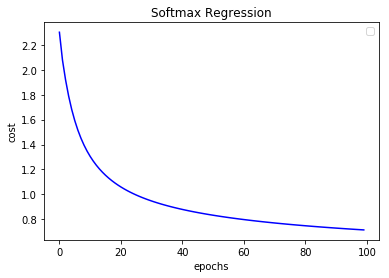

In [8]:
x,y  = process(df, n_classes)
x = X_train/255.
m = x.shape[0]
y = y_train.reshape(m, 1)
print('n_classes = ', n_classes)

#training
w,b, cost = softmax_regression(x,y, n_classes, 0.1, 100, 0.001)
y_hat = softmax(np.dot(x,w) + b)
predicted_classes = np.argmax(y_hat, axis = 1).reshape(m,1)
mask = np.where(predicted_classes == y, 1, 0)
right = np.sum(mask)
print("The number of right guesses on Train: ", right)
print("On Train: right/total = ", right/m)

# plot cost decay for training
plt.grid(False)
iterations = np.arange(100).reshape((100,1))
cost = np.asarray(cost)
plt.plot(iterations, cost, color = 'blue')
plt.title('Softmax Regression')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()
parameters = (w,b)


## Softmax Inference and confusion matrix

In [9]:
# inference
def softmax_inference(X_validation, y_validation, parameters):
  w, b = parameters
  X_validation = np.copy(X_validation)
  validation_size = X_validation.shape[0]
  y_validation = np.copy(y_validation).reshape(validation_size, 1)
  print(validation_size)

  y_hat_validation = softmax(np.dot(X_validation,w) + b)
  predicted_classes = np.argmax(y_hat_validation, axis = 1).reshape(validation_size,1)

  mask = np.where(predicted_classes == y_validation, 1, 0)

  right = np.sum(mask)
  print("The number of right guesses on validation: ", right)
  print("On Validation: right/total = ", right/validation_size)
  confusion = confusion_matrix(y_validation, predicted_classes)
  return confusion

 
confusion = softmax_inference(X_validation/255.0, y_validation, parameters)
np.savetxt("confusion.csv", confusion, delimiter=',', fmt='%2.0f')

print('Confusion')
print(confusion)


18000
The number of right guesses on validation:  13943
On Validation: right/total =  0.7746111111111111
Confusion
[[1435   12   29  173    9    0   79    0   35    0]
 [  12 1668   32   67   11    0    7    0    1    0]
 [  25    3 1210   17  398    0  145    0   45    1]
 [  63   24   14 1570   63    0   75    0    7    0]
 [   3   10  221  131 1336    0  116    0   12    0]
 [   1    0    2    1    2 1143    0  425   15  181]
 [ 420   10  266   86  301    1  669    0   55    0]
 [   0    0    0    0    0   36    0 1559    2  149]
 [   3    2   14   37   11    6   42   27 1677    1]
 [   0    0    0    1    1   16    1  101    1 1676]]


#**3.** Move on to **Neural Networks, using one hidden laye**r. You should implement your solution

In [10]:
def NN_onehidden(X, y, hidden_size ,n_classes, relu=True, eta=0.0000001, 
                 n_epoch=10):
    # random init
    W1 = np.random.rand(X.shape[1], hidden_size) *0.01
    b1 = np.random.rand(hidden_size)*0.01
    W2 = np.random.rand(hidden_size, n_classes)*0.01
    b2 = np.random.rand(n_classes)*0.01
    
    loss_list = []
    start_time = time.time()
    # for iter
    for iter in range(n_epoch):
      
        loss = 0.
        # feed foward
        z2 = np.matmul(X, W1) + np.tile(b1,(X.shape[0], 1))
        if relu:
          a2 = relu_(z2)
        else:
          a2 = sigmoid(z2)
        z3 = np.matmul(a2, W2) + np.tile(b2,(X.shape[0], 1))
        a3 = softmax(z3)
        prob = np.copy(a3)

        # compute loss
        log_prob = -1. * np.log(prob[range(len(X)), y])
        loss = np.sum(log_prob) / len(X)
        loss_list.append(loss)
        print(40*'*')
        print('training error @ %d: %.5f' %(iter, loss))  

        # back propag
        D_W2 = np.zeros_like(W2, dtype=np.float32)
        D_W1 = np.zeros_like(W1, dtype=np.float32)
        a3[range(len(X)),y] -= 1. # d_softmax
        delta3 = a3/len(X)
        D_W2 = D_W2 + np.matmul(a2.T, delta3)
        delta2 = np.matmul(delta3, W2.T)
        if relu:
            delta2[a2 <= 0] = 0
        else:
            delta2 = delta2 * (sigmoid(a2) * (1 - sigmoid(a2)))
        D_W1 = D_W1 + np.matmul(delta2.T, X).T

        # gradient descent
        W1 = W1 - (eta * D_W1)
        W2 = W2 - (eta * D_W2)
      
    print('train time:', time.time() - start_time)
    plt.title('1 hidden layer utilizando one-hot')
    plt.grid(False)
    plt.xlabel('epochs')
    plt.ylabel('cost')
    plt.plot(loss_list)
    
    return W1, W2, b1, b2

def make_prediction_without_onehot(X, y, W1, W2, b1, b2, relu=True):
    z2 = np.matmul(X, W1) + np.tile(b1,(X.shape[0], 1))
    if relu:
        a2 = relu_(z2)
    else:
        a2 = sigmoid(z2)
    z3 = np.matmul(a2, W2) + np.tile(b2,(X.shape[0], 1))
    a3 = softmax(z3)
    a3 = z3
    print(a3.shape)
    prob = np.zeros_like(a3, dtype=np.float32) 
    prob =softmax(a3)
    predictions = np.argmax(prob,axis=1)
    return predictions
  


****************************************
training error @ 0: 2.30198
****************************************
training error @ 1: 2.26736
****************************************
training error @ 2: 2.26366
****************************************
training error @ 3: 2.26061
****************************************
training error @ 4: 2.25712
****************************************
training error @ 5: 2.25282
****************************************
training error @ 6: 2.24724
****************************************
training error @ 7: 2.23971
****************************************
training error @ 8: 2.22912
****************************************
training error @ 9: 2.21374
****************************************
training error @ 10: 2.19149
****************************************
training error @ 11: 2.16216
****************************************
training error @ 12: 2.12407
****************************************
training error @ 13: 2.07566
******************************

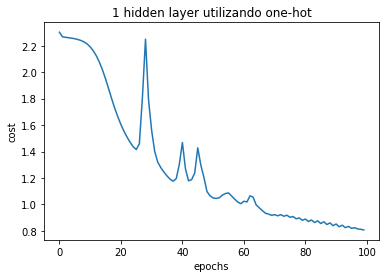

In [11]:
relu=True

W1,W2,b1,b2 = NN_onehidden(X_train/255., y_train, 20, 10,
                               n_epoch=100, eta=0.3, relu=relu)

pred_train = make_prediction_without_onehot(X_train/255., y_train, W1, W2, b1, b2, relu=relu)
pred_valid = make_prediction_without_onehot(X_validation/255., y_validation, W1, W2, b1, b2, relu=relu)

print('train pred: ', (pred_train == y_train).sum() *1. / len(y_train))
print('valid pred: ', (pred_valid == y_validation).sum() *1. / len(y_validation))

# 4. Extend your Neural Network to** two hidden layers**. Try different activation functions. Does the performance improve?

In [12]:
def NN_twohidden(X, y, hidden_size ,n_classes, relu=True, eta=0.0000001, 
                 n_epoch=10):
    # random init
    W1 = np.random.rand(X.shape[1], hidden_size) *0.01
    b1 = np.random.rand(hidden_size)*0.01
    W2 = np.random.rand(hidden_size, hidden_size)*0.01
    b2 = np.random.rand(hidden_size)*0.01
    W3 = np.random.rand(hidden_size, n_classes)*0.01
    b3 = np.random.rand(n_classes)*0.01    
    
    loss_list = []
    start_time = time.time()
    # for iter
    for iter in range(n_epoch):
      
        loss = 0.
        # feed foward
        z2 = np.matmul(X, W1) + np.tile(b1,(X.shape[0], 1))
        if relu:
            a2 = relu_(z2)
        else:
            a2 = sigmoid(z2)
        z3 = np.matmul(a2, W2) + np.tile(b2,(a2.shape[0], 1))
        if relu:
            a3 = relu_(z3)
        else:
            a3 = sigmoid(z3)
        z4 = np.matmul(a3, W3) + np.tile(b3,(a3.shape[0], 1))
        a4 = softmax(z4)
        prob = np.copy(a4)

        # compute loss
        log_prob = -1. * np.log(prob[range(len(X)), y])
        loss = np.sum(log_prob) / len(X)
        loss_list.append(loss)
        #print(40*'*')
        print('training error @ %d: %.5f' %(iter, loss))  

        # back propag
        D_W3 = np.zeros_like(W3, dtype=np.float32)
        D_W2 = np.zeros_like(W2, dtype=np.float32)
        D_W1 = np.zeros_like(W1, dtype=np.float32)
        a4[range(len(X)),y] -= 1. # d_softmax
        delta4 = a4/len(X)
        D_W3 = D_W3 + np.matmul(a3.T, delta4)
        delta3 = np.matmul(delta4, W3.T)
        if relu:
            delta3[a3 <= 0] = 0
        else:
            delta3 = delta3 * (sigmoid(a3) * (1 - sigmoid(a3)))
        D_W2 += np.matmul(delta3.T, z2).T
        delta2 = np.matmul(delta3, W2.T)
        if relu:
            delta2[a2 <= 0] = 0
        else:
            delta2 = delta2 * (sigmoid(a2) * (1 - sigmoid(a2)))
        D_W1 += np.matmul(delta2.T, X).T

        # gradient descent
        W1 = W1 - (eta * D_W1)
        W2 = W2 - (eta * D_W2)
        W3 = W3 - (eta * D_W3)

    print('train time:', time.time() - start_time)
    plt.title('2 hidden layers utilizando one-hot')
    plt.grid(False)
    plt.xlabel('epochs')
    plt.ylabel('cost')
    plt.plot(loss_list)
    
    return W1, W2, W3, b1, b2, b3

def make_prediction_twohidden(X, y, W1, W2, W3, b1, b2, b3, relu=True):
    z2 = np.matmul(X, W1) + np.tile(b1,(X.shape[0], 1))
    if relu:
        a2 = relu_(z2)
    else:
        a2 = sigmoid(z2)
    z3 = np.matmul(a2, W2) + np.tile(b2,(a2.shape[0], 1))
    if relu:
        a3 = relu_(z3)
    else:
        a3 = sigmoid(z3)
    z4 = np.matmul(a3, W3) + np.tile(b3,(a3.shape[0], 1))
    prob = np.zeros_like(z4, dtype=np.float32) 
    prob =softmax(z4)
    predictions = np.argmax(prob,axis=1)
    return predictions


training error @ 0: 2.30261
training error @ 1: 2.30199
training error @ 2: 2.30137
training error @ 3: 2.30070
training error @ 4: 2.29993
training error @ 5: 2.29902
training error @ 6: 2.29793
training error @ 7: 2.29661
training error @ 8: 2.29501
training error @ 9: 2.29309
training error @ 10: 2.29079
training error @ 11: 2.28811
training error @ 12: 2.28506
training error @ 13: 2.28169
training error @ 14: 2.27811
training error @ 15: 2.27447
training error @ 16: 2.27095
training error @ 17: 2.26768
training error @ 18: 2.26471
training error @ 19: 2.26203
training error @ 20: 2.25955
training error @ 21: 2.25714
training error @ 22: 2.25471
training error @ 23: 2.25216
training error @ 24: 2.24941
training error @ 25: 2.24639
training error @ 26: 2.24304
training error @ 27: 2.23926
training error @ 28: 2.23495
training error @ 29: 2.22997
training error @ 30: 2.22415
training error @ 31: 2.21725
training error @ 32: 2.20897
training error @ 33: 2.19938
training error @ 34: 2.1

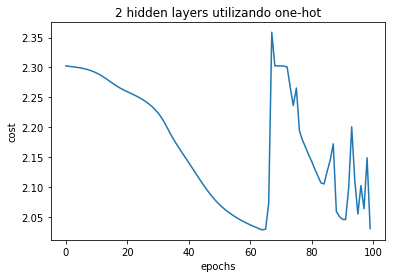

In [13]:
relu = False  
W1,W2,W3,b1,b2, b3 = NN_twohidden(X_train/255., y_train, 20, 10,
                               n_epoch=100, eta=0.3)

pred_train = make_prediction_twohidden(X_train/255., y_train, W1, W2, W3, b1, b2, b3)
pred_valid = make_prediction_twohidden(X_validation/255., y_validation, W1, W2, W3, b1, b2, b3)

print('train pred: ', (pred_train == y_train).sum() *1. / len(y_train))
print('valid pred: ', (pred_valid == y_validation).sum() *1. / len(y_validation))

# The best model
The best model chosen as the best was the neural network with one hidden layer, without regularization. Using the test for the first and last time.


In [14]:
with open('fashion-mnist_test.csv', 'rb') as csvfile:
    test = pd.read_csv('fashion-mnist_test.csv')

#normalize data
x_train = df.loc[:, 'pixel1':].values/255.
y_train = df.loc[:,'label'].values
x_test = test.loc[:, 'pixel1':].values/255.
y_test = test.loc[:,'label'].values

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)


x_train.shape =  (60000, 784)
y_train.shape =  (60000,)
x_test.shape =  (10000, 784)
y_test.shape =  (10000,)


****************************************
training error @ 0: 2.30389
****************************************
training error @ 1: 2.26713
****************************************
training error @ 2: 2.26325
****************************************
training error @ 3: 2.26022
****************************************
training error @ 4: 2.25686
****************************************
training error @ 5: 2.25285
****************************************
training error @ 6: 2.24785
****************************************
training error @ 7: 2.24136
****************************************
training error @ 8: 2.23263
****************************************
training error @ 9: 2.22045
****************************************
training error @ 10: 2.20294
****************************************
training error @ 11: 2.17865
****************************************
training error @ 12: 2.14753
****************************************
training error @ 13: 2.10891
******************************

****************************************
training error @ 117: 0.74092
****************************************
training error @ 118: 0.73421
****************************************
training error @ 119: 0.73334
****************************************
training error @ 120: 0.73086
****************************************
training error @ 121: 0.72627
****************************************
training error @ 122: 0.72813
****************************************
training error @ 123: 0.72001
****************************************
training error @ 124: 0.72630
****************************************
training error @ 125: 0.71472
****************************************
training error @ 126: 0.72591
****************************************
training error @ 127: 0.71054
****************************************
training error @ 128: 0.72628
****************************************
training error @ 129: 0.70783
****************************************
training error @ 130: 0.72796
******

****************************************
training error @ 233: 0.56837
****************************************
training error @ 234: 0.57332
****************************************
training error @ 235: 0.56546
****************************************
training error @ 236: 0.57023
****************************************
training error @ 237: 0.56302
****************************************
training error @ 238: 0.56747
****************************************
training error @ 239: 0.56096
****************************************
training error @ 240: 0.56510
****************************************
training error @ 241: 0.55911
****************************************
training error @ 242: 0.56303
****************************************
training error @ 243: 0.55747
****************************************
training error @ 244: 0.56199
****************************************
training error @ 245: 0.55668
****************************************
training error @ 246: 0.56416
******

****************************************
training error @ 350: 0.50859
****************************************
training error @ 351: 0.52146
****************************************
training error @ 352: 0.50831
****************************************
training error @ 353: 0.52149
****************************************
training error @ 354: 0.50742
****************************************
training error @ 355: 0.51833
****************************************
training error @ 356: 0.50428
****************************************
training error @ 357: 0.51317
****************************************
training error @ 358: 0.50072
****************************************
training error @ 359: 0.50898
****************************************
training error @ 360: 0.49852
****************************************
training error @ 361: 0.50744
****************************************
training error @ 362: 0.49823
****************************************
training error @ 363: 0.50828
******

****************************************
training error @ 466: 0.46120
****************************************
training error @ 467: 0.46165
****************************************
training error @ 468: 0.46084
****************************************
training error @ 469: 0.46519
****************************************
training error @ 470: 0.46648
****************************************
training error @ 471: 0.47886
****************************************
training error @ 472: 0.48094
****************************************
training error @ 473: 0.49898
****************************************
training error @ 474: 0.49307
****************************************
training error @ 475: 0.50363
****************************************
training error @ 476: 0.49187
****************************************
training error @ 477: 0.49772
****************************************
training error @ 478: 0.48861
****************************************
training error @ 479: 0.49182
******

****************************************
training error @ 582: 0.45075
****************************************
training error @ 583: 0.44726
****************************************
training error @ 584: 0.45013
****************************************
training error @ 585: 0.44616
****************************************
training error @ 586: 0.44818
****************************************
training error @ 587: 0.44434
****************************************
training error @ 588: 0.44574
****************************************
training error @ 589: 0.44247
****************************************
training error @ 590: 0.44361
****************************************
training error @ 591: 0.44088
****************************************
training error @ 592: 0.44199
****************************************
training error @ 593: 0.43979
****************************************
training error @ 594: 0.44118
****************************************
training error @ 595: 0.43947
******

****************************************
training error @ 699: 0.44953
****************************************
training error @ 700: 0.44371
****************************************
training error @ 701: 0.44257
****************************************
training error @ 702: 0.43589
****************************************
training error @ 703: 0.43416
****************************************
training error @ 704: 0.42968
****************************************
training error @ 705: 0.42922
****************************************
training error @ 706: 0.42616
****************************************
training error @ 707: 0.42687
****************************************
training error @ 708: 0.42491
****************************************
training error @ 709: 0.42652
****************************************
training error @ 710: 0.42487
****************************************
training error @ 711: 0.42723
****************************************
training error @ 712: 0.42575
******

****************************************
training error @ 816: 0.41782
****************************************
training error @ 817: 0.41732
****************************************
training error @ 818: 0.41624
****************************************
training error @ 819: 0.41622
****************************************
training error @ 820: 0.41531
****************************************
training error @ 821: 0.41565
****************************************
training error @ 822: 0.41473
****************************************
training error @ 823: 0.41533
****************************************
training error @ 824: 0.41426
****************************************
training error @ 825: 0.41532
****************************************
training error @ 826: 0.41387
****************************************
training error @ 827: 0.41558
****************************************
training error @ 828: 0.41365
****************************************
training error @ 829: 0.41625
******

****************************************
training error @ 932: 0.41851
****************************************
training error @ 933: 0.41243
****************************************
training error @ 934: 0.41692
****************************************
training error @ 935: 0.41078
****************************************
training error @ 936: 0.41311
****************************************
training error @ 937: 0.40773
****************************************
training error @ 938: 0.40884
****************************************
training error @ 939: 0.40487
****************************************
training error @ 940: 0.40590
****************************************
training error @ 941: 0.40310
****************************************
training error @ 942: 0.40460
****************************************
training error @ 943: 0.40254
****************************************
training error @ 944: 0.40435
****************************************
training error @ 945: 0.40253
******

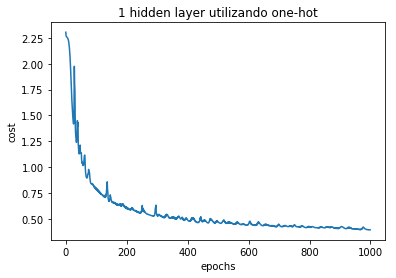

In [15]:
W1,W2,b1,b2 = NN_onehidden(x_train, y_train, 20, 10,
                               n_epoch=1000, eta=0.3)

pred_train = make_prediction_without_onehot(x_train, y_train, W1, W2, b1, b2)
pred_test = make_prediction_without_onehot(x_test, y_test, W1, W2, b1, b2)

print('train predictions: ', (pred_train == y_train).sum() *1. / len(y_train))
print('test predictions: ', (pred_test == y_test).sum() *1. / len(y_test))

In [16]:
print('Confusion Matrix')
confusion = confusion_matrix(y_test, pred_test)
print(confusion)

Confusion Matrix
[[869   8  14  22   5   0  61   0  20   1]
 [  2 976   4  13   2   1   2   0   0   0]
 [ 22   3 795   6 125   0  40   0   9   0]
 [ 46  31  15 843  43   0  17   0   5   0]
 [  2   1  86  20 834   0  55   0   2   0]
 [  3   1   0   0   0 905   0  60   8  23]
 [200   6 118  20 112   0 528   0  15   1]
 [  0   0   0   0   0  30   0 942   0  28]
 [  4   0   5   2   7   4   6   6 966   0]
 [  0   0   0   0   0  20   0  59   1 920]]


### Playing with the results

class =  4  , prediction =  3


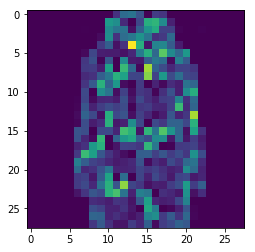

In [17]:
num_test = len(y_test)
random_int = random.randint(0, num_test-1)
example = x_train[random_int,:].copy()
example = np.reshape(example, (img_size, img_size))
plt.grid(False)
img_plot = plt.imshow(example)
print('class = ',y_test[random_int],' , prediction = ', pred_test[random_int])

# References
K- fold cross validation  
http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold

Gradient descent on a Softmax cross-entropy cost function
https://madalinabuzau.github.io/2016/11/29/gradient-descent-on-a-softmax-cross-entropy-cost-function.html
